# Thêm thư viện cần thiết


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 2.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [4]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/eth/ethereum_train_7_3.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.23180,0.24981,0.23085,0.24797,11970598,USD
2020-06-02,0.24801,0.25321,0.22795,0.23794,12686011,USD
2020-06-03,0.23790,0.24476,0.23384,0.24452,8151002,USD
2020-06-04,0.24453,0.24641,0.23668,0.24337,8749785,USD
2020-06-05,0.24337,0.24750,0.23970,0.24023,7754761,USD


In [5]:
train = train_ETH[["Close"]]
train.head(5)

,Close
Date,
2020-06-01,0.24797
2020-06-02,0.23794
2020-06-03,0.24452
2020-06-04,0.24337
2020-06-05,0.24023


In [6]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/eth/ethereum_test_7_3.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2021-10-26,4.21992,4.29198,4.09819,4.12951,559294,USD
2021-10-27,4.13006,4.29961,3.91406,3.92193,1068620,USD
2021-10-28,3.92154,4.28980,3.89633,4.28490,865802,USD
2021-10-29,4.28490,4.45830,4.26821,4.41370,781573,USD
2021-10-30,4.41370,4.42841,4.25024,4.32065,494872,USD


In [7]:
test = test_ETH[["Close"]]
test.head(5)

,Close
Date,
2021-10-26,4.12951
2021-10-27,3.92193
2021-10-28,4.28490
2021-10-29,4.41370
2021-10-30,4.32065


In [8]:
df = pd.concat([train.reset_index(level=0), test.reset_index(level=0)],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.index=df.Date
df.drop("Date", axis=1, inplace=True)
df.head(5)    

,Close
Date,
2020-06-01,0.24797
2020-06-02,0.23794
2020-06-03,0.24452
2020-06-04,0.24337
2020-06-05,0.24023


# Vẽ đồ thị

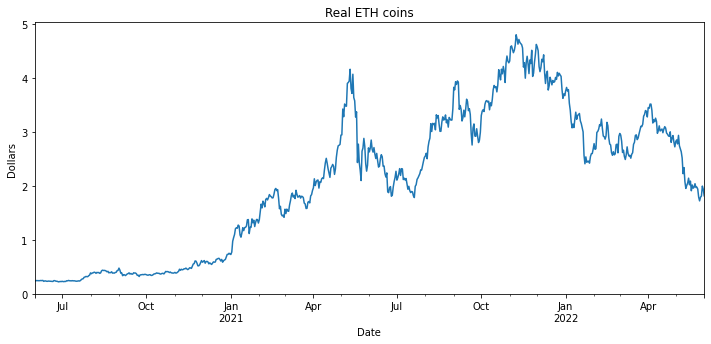

In [9]:
# Thư viện vẽ đồ thị
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real ETH coins'
ylabel='Dollars'
xlabel='Date' 

ax = df['Close'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Kiểm tra tính dừng của chuỗi

In [ ]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [ ]:
adf_test(df['Close'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.625923
p-value                     0.469625
Number of lags used         6.000000
Number of observations    724.000000
critical value (1%)        -3.439414
critical value (5%)        -2.865540
critical value (10%)       -2.568900
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [ ]:
df['diff1'] = df['Close'].diff()
df.head()


,Close,diff1
Date,,
2020-06-01,0.24797,NaN
2020-06-02,0.23794,-0.01003
2020-06-03,0.24452,0.00658
2020-06-04,0.24337,-0.00115
2020-06-05,0.24023,-0.00314


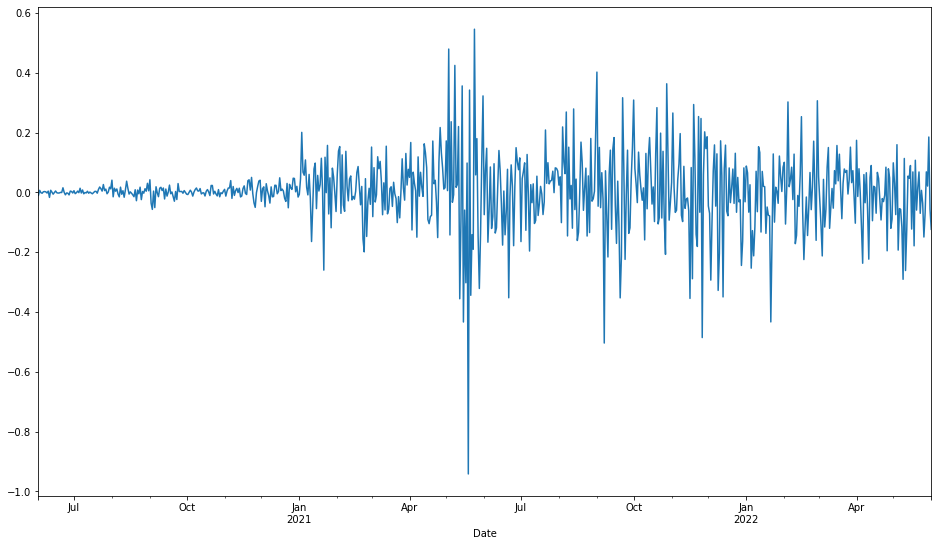

In [ ]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [ ]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic       -1.016000e+01
p-value                   7.551945e-18
Number of lags used       5.000000e+00
Number of observations    7.240000e+02
critical value (1%)      -3.439414e+00
critical value (5%)      -2.865540e+00
critical value (10%)     -2.568900e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [ ]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Close'] = scaler.fit_transform(df_scaled['Close'].values.reshape(-1, 1))
df_scaled.head()

,Close
Date,
2020-06-01,-1.385862
2020-06-02,-1.393427
2020-06-03,-1.388465
2020-06-04,-1.389332
2020-06-05,-1.391700


## Chia dữ liệu thành tập train và tập test

In [ ]:
interrupt = len(train)
interrupt

512

In [ ]:
index_test = df_scaled.index[interrupt:]
print(train.shape)
print(test.shape)
print(index_test.shape)

(512, 1)
(219, 1)
(219,)


In [ ]:
train.tail()

,Close
Date,
2021-10-21,4.05416
2021-10-22,3.97094
2021-10-23,4.16885
2021-10-24,4.08280
2021-10-25,4.21992


In [ ]:
test.head()

,Close
Date,
2021-10-26,4.12951
2021-10-27,3.92193
2021-10-28,4.28490
2021-10-29,4.41370
2021-10-30,4.32065


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [ ]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [ ]:
fitted = arima_model(train)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-780.166, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-774.074, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-780.486, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-779.410, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-773.662, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-780.476, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-783.835, Time=0.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-779.585, Time=1.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-782.172, Time=1.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-780.793, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-783.110, Time=0.50 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 7.178 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  512
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 395.917
Date:                Sat, 25 Jun 2022   AIC                           -783.835
Time:                        16:03:00   BIC                           -766.889
Sample:                             0   HQIC                          -777.191
                                - 512                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0142      0.009      1.599      0.110      -0.003       0.032
ar.L1         -0.8309      0.067    -12.446      0.000      -0.962      -0.700
ma.L1          0.7387      0.087      8.510      0.000       0.569       0.909
sigma2         0.0124      0.000     38.203      0.000       0.012       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              3075.23
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):             120.54   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [ ]:
pred = fitted.predict(len(test))
pred


array([4.20126987, 4.23094324, 4.22046607, 4.24334878, 4.23851376,
       4.25670857, 4.25576859, 4.27072713, 4.27247607, 4.28520046,
       4.28880568, 4.29998775, 4.30487445, 4.31499178, 4.32076313,
       4.33014543, 4.3365275 , 4.34540236, 4.35220604, 4.36073061,
       4.36782534, 4.37610808, 4.38340374, 4.39151953, 4.3989539 ,
       4.40695445, 4.41448457, 4.42240556, 4.43000179, 4.43786785,
       4.44550971, 4.45333785, 4.46101123, 4.46881319, 4.47650831,
       4.48429221, 4.49200234, 4.49977376, 4.50749426, 4.51525707,
       4.52298472, 4.53074158, 4.53847418, 4.54622694, 4.55396294,
       4.56171287, 4.56945123, 4.57719919, 4.58493918, 4.5926858 ,
       4.6004269 , 4.60817259, 4.61591447, 4.62365951, 4.63140193,
       4.63914653, 4.64688931, 4.6546336 , 4.66237664, 4.67012072,
       4.67786394, 4.68560787, 4.69335121, 4.70109504, 4.70883846,
       4.71658222, 4.7243257 , 4.73206942, 4.73981294, 4.74755662,
       4.75530016, 4.76304382, 4.77078739, 4.77853103, 4.78627

# Vẽ đồ thị cho tập test và kết quả dự đoán

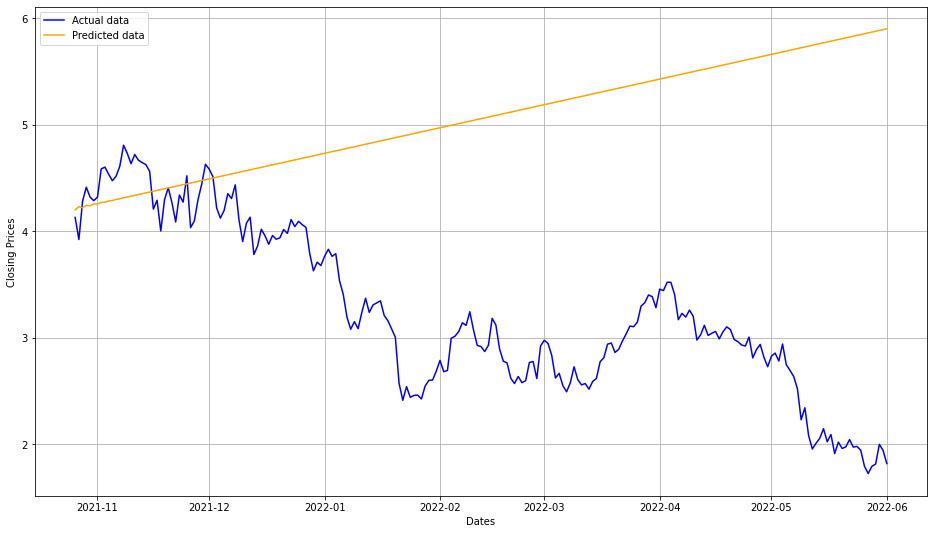

In [ ]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [ ]:
actual = column_or_1d(test)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


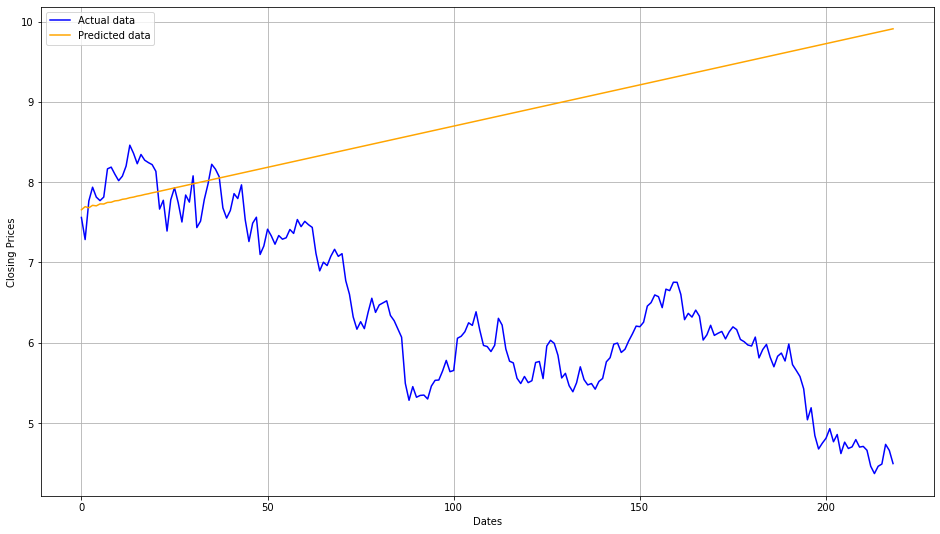

In [ ]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_actual, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [ ]:
# mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_actual, inv_pred)

# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MAPE: 43.51%
RMSE: 2.90
R2: -6.86
